In [1]:
import pytorch_lightning as pl
from lircst_ana_dataset import LircstAnaDataset
from encoded_conditional_latent_diffusion import ECLDiffusion
from Diffusion.EMA import EMA

dataset = LircstAnaDataset('/home/samnub/dev/lircst-ana/data/')

model = ECLDiffusion(
    train_dataset=dataset,
    lr=1e-4,
    batch_size=16,
)

trainer = pl.Trainer(
    max_steps=2e5,
    callbacks=[EMA(0.9999)],
    accelerator='gpu',
    devices=[0],
)

trainer.fit(model)

/home/samnub/anaconda3/envs/lircst-diffusion/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Is Time embed used ?  True


/home/samnub/dev/lircst-diffusion/src/Diffusion/EMA.py:58: UserWarning: EMA has better performance when Apex is installed: https://github.com/NVIDIA/apex#installation.
  rank_zero_warn(
You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                              | Params | Mode 
--------------------------------------------------------------------
0 | model | EncodedConditionalLat

Epoch 0:   0%|          | 1/1159 [00:00<16:05,  1.20it/s, v_num=18, train_loss=1.010]

/home/samnub/anaconda3/envs/lircst-diffusion/lib/python3.13/site-packages/pytorch_lightning/core/module.py:441: You are trying to `self.log()` but the `self.trainer` reference is not registered on the model yet. This is most likely because the model hasn't been passed to the `Trainer`


Epoch 172:  56%|█████▋    | 652/1159 [07:16<05:39,  1.49it/s, v_num=18, train_loss=0.00237]  

`Trainer.fit` stopped: `max_steps=200000.0` reached.


Epoch 172:  56%|█████▋    | 652/1159 [07:17<05:40,  1.49it/s, v_num=18, train_loss=0.00237]


In [17]:
# Use the model

import torch
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from encoded_conditional_latent_diffusion import ECLDiffusion
from lircst_ana_dataset import LircstAnaDataset
from Diffusion.DenoisingDiffusionProcess.samplers import DDIM_Sampler
from Diffusion.DenoisingDiffusionProcess.samplers import DDPM_Sampler


dataset = LircstAnaDataset('/home/samnub/dev/lircst-ana/data/')


trained_model = ECLDiffusion.load_from_checkpoint("/home/samnub/dev/lircst-diffusion/src/lightning_logs/version_18/checkpoints/epoch=172-step=200000.ckpt",
                                                 train_dataset = dataset,
                                                 lr=1e-4,
                                                 batch_size=16,)

trained_model.cuda()
trained_model.eval()

phan, sino, _ = dataset[17000]
sino = torch.from_numpy(sino)
batch_input = torch.stack(4*[sino]).cuda()

# Seems like the inference-time DDIM sampler that they provided is bugged
ddpm_sampler=DDPM_Sampler(trained_model.model.train_timesteps)
trained_model.model.diffusion_process.sampler = ddpm_sampler

out, encoded_condition = trained_model(batch_input, sampler=ddpm_sampler, verbose=True)

print(out.shape)


Is Time embed used ?  True


diffusion sampling: 100%|██████████| 1000/1000 [00:17<00:00, 57.76it/s]

torch.Size([4, 3, 256, 256])


0.2939683224803458
0.0
Output range:
-0.0388664 1.0470725
GT range:
-1.0 1.0
Input range:
tensor(-1.) tensor(1.)
Encoded condition range:
-1.0 0.9919044


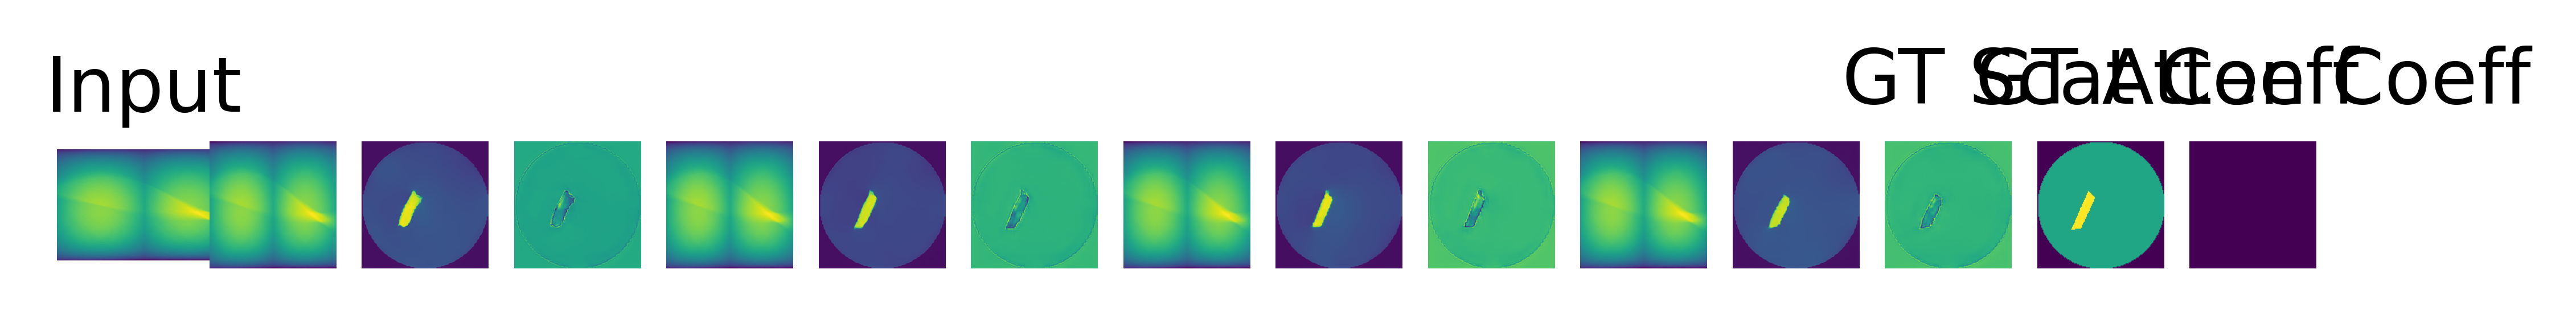

In [18]:

plt.figure(dpi=800)
plt.subplot(1,3+len(out)*2,1)
plt.imshow(torch.sum(sino, axis=2))
plt.title('Input')
plt.axis('off')
for idx in range(out.shape[0]*3):
    if idx % 3 == 1:
        continue
    if idx % 3 == 2:
        continue
    plt.subplot(1,3+len(out)*3,idx+2)
    plt.imshow(torch.sum(encoded_condition[idx//3].detach().cpu(), axis=0))
    plt.axis('off')
    plt.subplot(1,3+len(out)*3,idx+3)
    plt.imshow(out[idx//3].detach().cpu()[0])
    plt.axis('off')
    plt.subplot(1,3+len(out)*3,idx+4)
    plt.imshow(out[idx//3].detach().cpu()[1])
    plt.axis('off')
plt.subplot(1,3+len(out)*3,2+len(out)*3)
plt.imshow(phan[0])
plt.title('GT Scat Coeff')
plt.axis('off')
plt.subplot(1,3+len(out)*3,3+len(out)*3)
plt.imshow(phan[1])
plt.title('GT Atten Coeff')
plt.axis('off')


# Compare with GT using SSIM
from skimage.metrics import structural_similarity as ssim

def compare_images(imageA, imageB):
    # Compute SSIM between two images
    
    # If images aren't the same size, resize them
    if imageA.shape != imageB.shape:
        imageA = np.resize(imageA, imageB.shape)

    # P.S. Scikit-image returns a value between -1 and 1, where 1 is a perfect match and -1 is a complete mismatch
    s = ssim(imageA, 
             imageB, 
             multichannel=True,
             data_range=imageB.max() - imageB.min())
    return s

print(compare_images(out[0].detach().cpu().numpy()[0], phan[0]))
print(compare_images(out[0].detach().cpu().numpy()[1], phan[1]))

# Also print the range of the output
print("Output range:")
print(out[0].detach().cpu().numpy()[0].min(), out[0].detach().cpu().numpy()[0].max())
# Also print the range of the GT
print("GT range:")
print(phan[0].min(), phan[0].max())
# Also print the range of the input
print("Input range:")
print(sino.min(), sino.max())
# Also print the range of the encoded condition
print("Encoded condition range:")
print(encoded_condition[0].detach().cpu().numpy()[0].min(), encoded_condition[0].detach().cpu().numpy()[0].max())